# Evaluation of TSP Solvers

## Import Relevant Libraries

In [44]:
from gettext import install

import sys
import os
import time

import numpy as np
import pandas as pd

# Import from matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Import from scipy
from scipy.spatial import distance_matrix
# from scipy.optimize import linprog

# Import from python-tsp
from python_tsp.exact import solve_tsp_dynamic_programming as dynamic_programming

## Testing using a randomly generated distance matrix

### Creating the matrix

In [45]:
def generate_random_points(n, seed=None):
    np.random.seed(seed)
    return np.random.rand(n, 2)*1000

In [46]:
test = generate_random_points(10, seed=42)
print(test)

[[374.54011885 950.71430641]
 [731.99394181 598.6584842 ]
 [156.01864044 155.99452034]
 [ 58.08361217 866.17614577]
 [601.11501174 708.0725778 ]
 [ 20.5844943  969.90985216]
 [832.4426408  212.33911068]
 [181.82496721 183.40450985]
 [304.24224296 524.75643163]
 [431.94501864 291.2291402 ]]


In [47]:
def generate_distance_matrix(points):
    return distance_matrix(points, points)

In [48]:
dist = generate_distance_matrix(test)
print(dist)

[[   0.          501.71360108  824.21549057  327.55369212  331.98070811
   354.47574406  868.83407466  791.1406029   431.71970356  661.97885689]
 [ 501.71360108    0.          726.42889032  725.06608779  170.58938482
   802.45310158  399.16487757  689.29076871  434.0887343   429.58370296]
 [ 824.21549057  726.42889032    0.          716.90251142  709.15510382
   825.10640243  678.7666323    37.64670007  397.43626353  307.28450757]
 [ 327.55369212  725.06608779  716.90251142    0.          565.57920677
   110.30351618 1013.47657777  693.89410559  420.90556271  685.81076871]
 [ 331.98070811  170.58938482  709.15510382  565.57920677    0.
   636.84726578  547.05040205  671.62543353  348.91008912  449.8632437 ]
 [ 354.47574406  802.45310158  825.10640243  110.30351618  636.84726578
     0.         1110.41752436  802.86309143  527.84778695  793.61513959]
 [ 868.83407466  399.16487757  678.7666323  1013.47657777  547.05040205
  1110.41752436    0.          651.26075294  613.67763745  408.193

### Using Dynamic Programming

In [49]:
def dynamic_prog(dist):
    # Check if the number of points is too large (i.e. >= 20)
    if len(dist) >= 20:
        print("The number of points is too large for dynamic programming.")
        return -1, -1
    
    result = dynamic_programming(dist)
    
    # Return back to depot
    result[0].append(0)
    return result

result = dynamic_prog(dist)
print(result[0], result[1])

[0, 4, 1, 6, 9, 7, 2, 8, 3, 5, 0] 2903.067737777875


### Using Christofides

In [50]:
class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)
    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):
    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST

In [51]:
# Christofides algorithm
## https://github.com/Retsediv/ChristofidesAlgorithm
from collections import defaultdict

def christofides(dist):
    # build a graph
    G = defaultdict(dict)
    # print("Graph: ", G)

    for i in range(len(dist)):
        for j in range(len(dist[i])):
            if i != j:
                G[i][j] = dist[i][j]

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    # print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    # print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    # print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    # print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[eulerian_tour[0]] = True
    length = 0
    
    for v in eulerian_tour:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    length +=G[current][eulerian_tour[0]]
    path.append(eulerian_tour[0])

    # print("Result path: ", path)
    # print("Result length of the path: ", length)

    return path, length

### Using Greedy Nearest Neighbour

In [52]:
import fast_tsp

def greedy(dist):
    pairwise_dist = (dist * 1000).astype(int)
    tour = fast_tsp.greedy_nearest_neighbor(pairwise_dist)

    # Need to return back to depot
    tour.append(0)
    
    total_dist = 0
    for i in range(len(tour)-1):
        total_dist += dist[tour[i], tour[i+1]]
    return tour, total_dist

### Using OR-Tools

In [53]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

class ORTools:
    def __init__(self, dist_matrix):
        self.dist_matrix = dist_matrix
        self.manager = pywrapcp.RoutingIndexManager(len(self.dist_matrix), 1, 0)
        self.routing = pywrapcp.RoutingModel(self.manager)
        self.solution = self.solve()

    def distance_callback(self, from_index, to_index):
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = self.manager.IndexToNode(from_index)
        to_node = self.manager.IndexToNode(to_index)
        distance_matrix = self.dist_matrix.astype(int)

        return distance_matrix[from_node][to_node]
    
    def solve(self):
        transit_callback_index = self.routing.RegisterTransitCallback(self.distance_callback)
        self.routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        self.search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        self.search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        solution = self.routing.SolveWithParameters(self.search_parameters)
        return solution
        
    def print_solution(self):
        # Initial index
        index = self.routing.Start(0)
        route_distance = 0
        route = []

        while not self.routing.IsEnd(index):
            route.append(self.manager.IndexToNode(index))
            previous_index = index
            index = self.solution.Value(self.routing.NextVar(index))
            # route_distance += self.routing.GetArcCostForVehicle(previous_index, index, 0)
            if index == len(self.dist_matrix):
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(0)]
            else:
                route_distance += self.dist_matrix[self.manager.IndexToNode(previous_index), self.manager.IndexToNode(index)]

        # Return back to depot
        route.append(self.manager.IndexToNode(0))
    
        return route, route_distance
        

In [54]:
def or_tools(distance_matrix):
    # Create the routing index manager.
    ortool = ORTools(distance_matrix)
    return ortool.print_solution()

### Final Output

In [55]:
def evaluate(solvers, distance_matrix, instance_name=None, num_dests=None):
    # Input arguments: 
    # solvers - dict(name: str, solver: function)
    # distance_matrix - n-by-n matrix containing pairwise distances
    # instance_name - name of the instance
    # num_dests - number of destinations to visit

    if num_dests is None:
        num_dests = len(distance_matrix) - 1

    results = {}
    for name, solver in solvers.items():
        start = time.time_ns()
        result = solver(distance_matrix)
        end = time.time_ns()

        results[name] = {
            'instance': instance_name,
            'sequence': result[0],
            'distance (m)': result[1],
            'time (ns)': end - start,
            'num_dests': num_dests
        }

    # print(results)
    # result = {"name_of_solver": {"result": order of seq,
    #                              "distance": distance travelled.
    #                              "time": time taken to find a solution}}
    return results


def plot_points(points, tour=None):
    plt.scatter(points[:, 0], points[:, 1])
    if tour is not None and tour != -1:
        for i in range(len(tour)):
            plt.plot([points[tour[i-1], 0], points[tour[i], 0]], [points[tour[i-1], 1], points[tour[i], 1]], 'r-')
    plt.show()


def plot_results(points, results, distance_matrix):
    plot_points(points)
    
    print(results)

    for name, result in results.items():
        tour = result['sequence']
        if tour is not None and tour != -1:
            plot_points(points, tour)
            print(f'{name} - Length: {sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1))}')

        else:
            print(f'{name} - No solution found')
        print(f'{name} - Time: {result["time (ns)"]} ns\n')

The number of points is too large for dynamic programming.


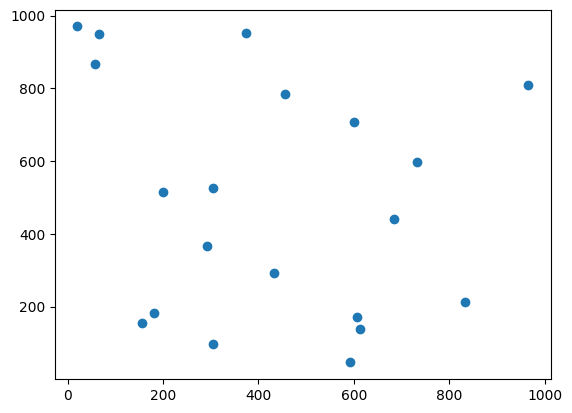

{'Greedy': {'instance': None, 'sequence': [0, 12, 4, 1, 19, 6, 15, 10, 14, 18, 7, 2, 11, 9, 8, 13, 3, 16, 5, 17, 0], 'distance (m)': 4650.384155596448, 'time (ns)': 0, 'num_dests': 19}, 'Christofides': {'instance': None, 'sequence': [15, 10, 14, 9, 11, 8, 13, 7, 18, 2, 5, 16, 3, 0, 12, 4, 1, 17, 19, 6, 15], 'distance (m)': 4564.619094619012, 'time (ns)': 0, 'num_dests': 19}, 'OR Tools': {'instance': None, 'sequence': [0, 16, 5, 3, 13, 8, 11, 9, 7, 2, 18, 14, 10, 15, 6, 19, 1, 17, 4, 12, 0], 'distance (m)': 3866.266770061002, 'time (ns)': 6095700, 'num_dests': 19}, 'Dynamic Programming': {'instance': None, 'sequence': -1, 'distance (m)': -1, 'time (ns)': 0, 'num_dests': 19}}


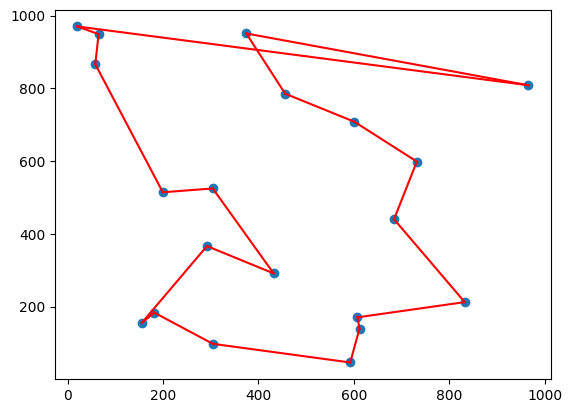

Greedy - Length: 4650.384155596448
Greedy - Time: 0 ns



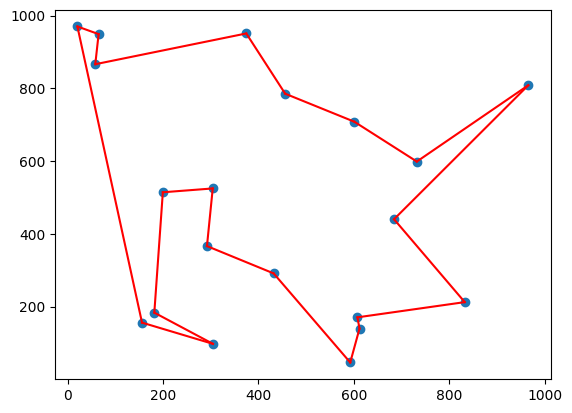

Christofides - Length: 4564.619094619012
Christofides - Time: 0 ns



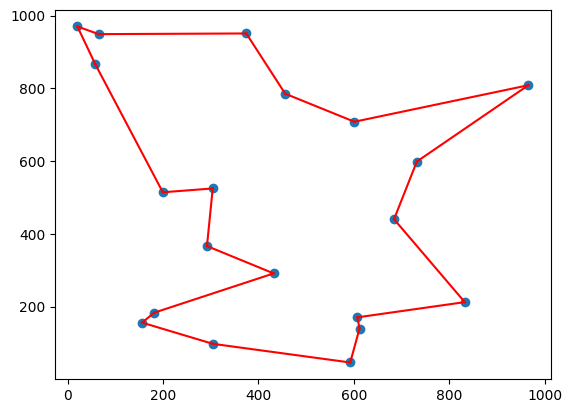

OR Tools - Length: 3866.266770061002
OR Tools - Time: 6095700 ns

Dynamic Programming - No solution found
Dynamic Programming - Time: 0 ns



In [56]:
def main():
    n = 20
    seed = 42
    sample_points = generate_random_points(n, seed)
    distance_matrix = generate_distance_matrix(sample_points)

    solvers = {
        'Greedy': greedy,
        'Christofides': christofides,
        'OR Tools': or_tools,
        'Dynamic Programming': dynamic_prog,
    }

    results = evaluate(solvers, distance_matrix)

    plot_results(sample_points, results, distance_matrix)

main()

## Executing Solvers on all Problem Instances

In [57]:
from pathlib import Path
import glob
from tqdm.notebook import tqdm

In [58]:
res = glob.glob("../processed_heuristic-threshold/instances/1/*/*")
print(res)

['../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1002_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1003_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1005_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1007_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1008_courier_967', '../processed_heuristic-threshold/instances/1\\1\\ds_1014_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1015_courier_218', '../processed_heuristic-threshold/instances/1\\1\\ds_1019_courier_1520', '../processed_heuristic-threshold/instances/1\\1\\ds_1020_courier_1558', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_3030', '../processed_heuristic-threshold/instances/1\\1\\ds_1021_courier_87', '../processed_heuristic-threshold/instances/1\\1\\ds_1022_c

In [59]:
def run_solvers(file_path, solvers):
    path = Path(file_path)
    print(path)
    
    result = None
    if path.is_dir():
        with np.load(path / 'pairwise.npz') as data:
            dist_matrix = data["arr_0"]

        if len(dist_matrix) > 3:
            num_dest = dist_matrix.shape[0] - 1

            result = evaluate(solvers, dist_matrix, path.name, num_dests=num_dest)
            print(result, end="\n\n")

            return result
    return None

In [60]:
def generate_solver_df(file_paths):
    solvers = {
    'Greedy': greedy,
    'Christofides': christofides,
    'OR Tools': or_tools,
    }

    greedy_results = []
    christofides_results = []
    or_tools_results = []
    # dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)
        
        if result is None:
            continue

        for key, value in result.items():
            if key == "Greedy":
                greedy_results.append(value)
            elif key == "Christofides":
                christofides_results.append(value)
            elif key == "OR Tools":
                or_tools_results.append(value)
    
    greedy_df = pd.DataFrame(greedy_results)
    christofides_df = pd.DataFrame(christofides_results)
    or_tools_df = pd.DataFrame(or_tools_results)

    greedy_df.to_csv("../results/greedy_results.csv", index=False)
    christofides_df.to_csv("../results/christofides_results.csv", index=False)
    or_tools_df.to_csv("../results/or_tools_results.csv", index=False)

    return greedy_df, christofides_df, or_tools_df, #dynamic_prog_df

In [61]:
generate_solver_df(res)

  0%|          | 0/1492 [00:00<?, ?it/s]

..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_218
None
..\processed_heuristic-threshold\instances\1\1\ds_1002_courier_967
None
..\processed_heuristic-threshold\instances\1\1\ds_1003_courier_218
None
..\processed_heuristic-threshold\instances\1\1\ds_1005_courier_218
None
..\processed_heuristic-threshold\instances\1\1\ds_1007_courier_218
None
..\processed_heuristic-threshold\instances\1\1\ds_1007_courier_3030
None
..\processed_heuristic-threshold\instances\1\1\ds_1008_courier_967
None
..\processed_heuristic-threshold\instances\1\1\ds_1014_courier_3030
None
..\processed_heuristic-threshold\instances\1\1\ds_1015_courier_218
None
..\processed_heuristic-threshold\instances\1\1\ds_1019_courier_1520
None
..\processed_heuristic-threshold\instances\1\1\ds_1020_courier_1558
None
..\processed_heuristic-threshold\instances\1\1\ds_1021_courier_3030
None
..\processed_heuristic-threshold\instances\1\1\ds_1021_courier_87
None
..\processed_heuristic-threshold\instances\1\1\ds_1022_couri

(                  instance                               sequence  \
 0     ds_1004_courier_1656  [0, 6, 2, 1, 3, 8, 10, 5, 4, 7, 9, 0]   
 1       ds_1010_courier_87  [0, 8, 5, 4, 6, 3, 1, 2, 7, 10, 9, 0]   
 2     ds_1015_courier_1558  [0, 1, 10, 8, 4, 6, 2, 5, 3, 7, 9, 0]   
 3     ds_1016_courier_1558  [0, 1, 6, 8, 3, 4, 5, 2, 9, 7, 10, 0]   
 4      ds_524_courier_2208  [0, 9, 3, 6, 5, 4, 1, 7, 2, 8, 10, 0]   
 ...                    ...                                    ...   
 1266   ds_910_courier_1558      [0, 5, 4, 1, 2, 3, 6, 7, 8, 9, 0]   
 1267    ds_919_courier_487      [0, 3, 4, 5, 6, 1, 9, 2, 7, 8, 0]   
 1268   ds_920_courier_1656      [0, 3, 4, 5, 2, 8, 6, 7, 9, 1, 0]   
 1269    ds_920_courier_487      [0, 4, 6, 7, 1, 2, 5, 9, 3, 8, 0]   
 1270    ds_926_courier_487      [0, 8, 7, 6, 4, 5, 2, 9, 1, 3, 0]   
 
       distance (m)  time (ns)  num_dests  
 0     13175.950861          0         10  
 1      6713.723326          0         10  
 2       154.025031       

In [62]:
def generate_solver_df(file_paths):
    solvers = {
    'Dynamic Programming': dynamic_prog,
    }

    dynamic_prog_results = []

    for path in tqdm(file_paths):
        result = run_solvers(path, solvers)
        print(result)

        if result is None:
            continue
        
        for key, value in result.items():
            if key == "Dynamic Programming":
                dynamic_prog_results.append(value)
    
    dynamic_prog_df = pd.DataFrame(dynamic_prog_results)

    dynamic_prog_df.to_csv("../results/dynamic_prog_results.csv", index=False)

    return dynamic_prog_df

In [63]:
if not os.path.exists("../results/dynamic_prog_results.csv"):
    generate_solver_df(res)

## Results Evaluation

### Import Results from CSV

In [64]:
import pandas as pd
import numpy as np

In [65]:
RESULTS_DIR = "../results"

CHRISTOFIDES = RESULTS_DIR + "/christofides_results.csv"
DYNAMIC_PROG = RESULTS_DIR + "/dynamic_prog_results.csv"
OR_TOOLS = RESULTS_DIR + "/or_tools_results.csv"
GREEDY = RESULTS_DIR + "/greedy_results.csv"
GNN_BEAM_5 = RESULTS_DIR + "/gnn_v1_beam_5_results.csv"
GNN_BEAM_10 = RESULTS_DIR + "/gnn_v1_beam_10_results.csv"

In [66]:
def load_results(file_path):
    return pd.read_csv(file_path)

def str_to_list(row):
    if row == "-1":
        return np.nan
    else:
        lst = row.strip('][').split(', ')
        return lst

In [67]:
christofides_df = load_results(CHRISTOFIDES).sort_values(by="instance").reset_index(drop=True)
or_tools_df = load_results(OR_TOOLS).sort_values(by="instance").reset_index(drop=True)
greedy_df = load_results(GREEDY).sort_values(by="instance").reset_index(drop=True)
dynamic_prog_df = load_results(DYNAMIC_PROG).sort_values(by="instance").reset_index(drop=True)

In [68]:
gnn_beam_5_df = load_results(GNN_BEAM_5).sort_values(by="instances").reset_index(drop=True)
gnn_beam_10_df = load_results(GNN_BEAM_5).sort_values(by="instances").reset_index(drop=True)

gnn_beam_5_df.rename(columns={"instances": "instance", "distances (m)": "distance (m)"}, inplace=True)
gnn_beam_10_df.rename(columns={"instances": "instance", "distances (m)": "distance (m)"}, inplace=True)

In [69]:
christofides_df["sequence"] = christofides_df["sequence"].apply(str_to_list)
or_tools_df["sequence"] = or_tools_df["sequence"].apply(str_to_list)
greedy_df["sequence"] = greedy_df["sequence"].apply(str_to_list)
dynamic_prog_df["sequence"] = dynamic_prog_df["sequence"].apply(str_to_list)

gnn_beam_5_df["sequence"] = gnn_beam_5_df["sequence"].apply(str_to_list)
gnn_beam_10_df["sequence"] = gnn_beam_10_df["sequence"].apply(str_to_list)

In [70]:
christofides_df = christofides_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
or_tools_df = or_tools_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
greedy_df = greedy_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
dynamic_prog_df = dynamic_prog_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})

gnn_beam_5_df = gnn_beam_5_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})
gnn_beam_10_df = gnn_beam_10_df.astype({"instance": str, "distance (m)": "float64", "time (ns)": "int64", "num_dests": "int64"})

In [71]:
# print(christofides_df.dtypes)
# print(or_tools_df.dtypes)
# print(greedy_df.dtypes)
# print(dynamic_prog_df.dtypes)

# print(gnn_beam_5_df.dtypes)
# print(gnn_beam_10_df.dtypes)

In [72]:
christofides_df.replace({"time (ns)": 0}, np.nan, inplace=True)
christofides_df.rename(columns={"sequence": "christofides_sequence", "distance (m)": "christofides_distance", "time (ns)": "christofides_time"}, inplace=True)

display(christofides_df)

,instance,christofides_sequence,christofides_distance,christofides_time,num_dests
0,ds_1001_courier_1103,"[20, 19, 18, 14, 17, 0, 13, 7, 6, 1, 2, 8, 10,...",20307.435934,NaN,21
1,ds_1001_courier_1520,"[17, 13, 12, 0, 1, 2, 24, 4, 28, 20, 18, 11, 6...",10347.929757,999800.0,29
2,ds_1001_courier_1656,"[14, 0, 2, 8, 5, 4, 13, 10, 12, 9, 6, 11, 7, 3...",19600.813044,NaN,14
3,ds_1001_courier_2688,"[13, 7, 6, 17, 10, 21, 15, 18, 16, 11, 12, 19,...",12307.065736,NaN,21
4,ds_1001_courier_2945,"[7, 6, 14, 5, 11, 12, 13, 10, 27, 19, 26, 22, ...",13243.076451,1002600.0,27
...,...,...,...,...,...
1266,ds_930_courier_290,"[5, 4, 7, 12, 9, 6, 3, 10, 1, 11, 8, 2, 0, 14,...",8991.205735,1001100.0,14
1267,ds_930_courier_435,"[11, 3, 7, 15, 6, 2, 4, 14, 10, 9, 1, 12, 5, 0...",9879.988782,NaN,15
1268,ds_930_courier_4474,"[10, 8, 7, 2, 4, 6, 3, 20, 0, 1, 18, 11, 19, 1...",10174.856988,NaN,20
1269,ds_930_courier_487,"[11, 10, 12, 8, 9, 0, 7, 6, 5, 3, 4, 1, 14, 2,...",16594.787701,NaN,14


In [73]:
or_tools_df.rename(columns={"sequence": "or_tools_sequence", "distance (m)": "or_tools_distance", "time (ns)": "or_tools_time"}, inplace=True)

display(or_tools_df)

,instance,or_tools_sequence,or_tools_distance,or_tools_time,num_dests
0,ds_1001_courier_1103,"[0, 15, 21, 20, 19, 18, 14, 17, 16, 9, 10, 8, ...",17324.195317,13129900,21
1,ds_1001_courier_1520,"[0, 12, 13, 17, 22, 7, 21, 3, 27, 20, 11, 18, ...",8341.080239,16009300,29
2,ds_1001_courier_1656,"[0, 14, 3, 6, 11, 7, 9, 13, 10, 4, 12, 5, 8, 2...",17292.137023,5505400,14
3,ds_1001_courier_2688,"[0, 19, 16, 18, 15, 21, 17, 10, 2, 3, 5, 4, 8,...",11047.248526,9029700,21
4,ds_1001_courier_2945,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 9, 18,...",12696.919432,11991200,27
...,...,...,...,...,...
1266,ds_930_courier_290,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 9, 7, 4, 5,...",8666.253003,2502500,14
1267,ds_930_courier_435,"[0, 13, 12, 9, 1, 14, 2, 4, 10, 8, 11, 3, 7, 1...",9024.117062,7009100,15
1268,ds_930_courier_4474,"[0, 9, 5, 10, 8, 7, 2, 1, 11, 19, 12, 16, 13, ...",8634.285049,5999400,20
1269,ds_930_courier_487,"[0, 7, 6, 5, 3, 4, 2, 14, 1, 13, 11, 10, 8, 9,...",15814.126768,3001300,14


In [74]:
greedy_df.replace({"time (ns)": 0}, np.nan, inplace=True)
greedy_df.rename(columns={"sequence": "greedy_sequence", "distance (m)": "greedy_distance", "time (ns)": "greedy_time"}, inplace=True)

display(greedy_df)

,instance,greedy_sequence,greedy_distance,greedy_time,num_dests
0,ds_1001_courier_1103,"[0, 13, 12, 11, 15, 20, 19, 21, 18, 14, 17, 7,...",20129.150350,NaN,21
1,ds_1001_courier_1520,"[0, 1, 12, 17, 13, 22, 7, 21, 3, 27, 20, 4, 28...",9609.178661,NaN,29
2,ds_1001_courier_1656,"[0, 14, 1, 6, 11, 7, 12, 4, 13, 9, 5, 8, 2, 10...",19079.531559,NaN,14
3,ds_1001_courier_2688,"[0, 19, 12, 11, 16, 18, 15, 20, 14, 21, 17, 6,...",12691.013943,NaN,21
4,ds_1001_courier_2945,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 26, 19...",13372.186482,NaN,27
...,...,...,...,...,...
1266,ds_930_courier_290,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 7, 4, 5, 13...",8871.835625,NaN,14
1267,ds_930_courier_435,"[0, 13, 12, 5, 8, 11, 3, 7, 15, 6, 9, 1, 10, 4...",9985.032204,NaN,15
1268,ds_930_courier_4474,"[0, 2, 7, 8, 10, 5, 9, 1, 18, 17, 15, 16, 14, ...",9228.206103,NaN,20
1269,ds_930_courier_487,"[0, 7, 6, 5, 3, 1, 14, 2, 4, 13, 11, 10, 12, 8...",16434.215974,NaN,14


In [75]:
gnn_beam_5_df.rename(columns={"sequence": "gnn_beam_5_sequence", "distance (m)": "gnn_beam_5_distance", "time (ns)": "gnn_beam_5_time"}, inplace=True)
# gnn_beam_5_df.isna().sum()
display(gnn_beam_5_df)

,instance,gnn_beam_5_sequence,gnn_beam_5_distance,gnn_beam_5_time,num_dests
0,ds_1001_courier_1103,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",44395.808594,6995200,21
1,ds_1001_courier_1520,"[0, 1, 6, 18, 4, 17, 15, 10, 3, 22, 2, 5, 16, ...",29089.755859,7997600,29
2,ds_1001_courier_1656,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",29561.208984,5999100,14
3,ds_1001_courier_2688,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",26425.156250,6998200,21
4,ds_1001_courier_2945,"[0, 1, 6, 17, 4, 15, 12, 25, 23, 21, 18, 2, 11...",35510.277344,6995500,27
...,...,...,...,...,...
1266,ds_930_courier_290,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",21147.964844,6000100,14
1267,ds_930_courier_435,"[0, 1, 4, 10, 3, 14, 12, 6, 15, 11, 8, 2, 5, 9...",15834.768555,3999800,15
1268,ds_930_courier_4474,"[0, 1, 5, 13, 4, 6, 3, 16, 11, 2, 18, 9, 14, 1...",23464.189453,5996500,20
1269,ds_930_courier_487,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",45433.195312,3998800,14


In [76]:
gnn_beam_10_df.rename(columns={"sequence": "gnn_beam_10_sequence", "distance (m)": "gnn_beam_10_distance", "time (ns)": "gnn_beam_10_time"}, inplace=True)
# gnn_beam_10_df.isna().sum()
display(gnn_beam_10_df)

,instance,gnn_beam_10_sequence,gnn_beam_10_distance,gnn_beam_10_time,num_dests
0,ds_1001_courier_1103,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",44395.808594,6995200,21
1,ds_1001_courier_1520,"[0, 1, 6, 18, 4, 17, 15, 10, 3, 22, 2, 5, 16, ...",29089.755859,7997600,29
2,ds_1001_courier_1656,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",29561.208984,5999100,14
3,ds_1001_courier_2688,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",26425.156250,6998200,21
4,ds_1001_courier_2945,"[0, 1, 6, 17, 4, 15, 12, 25, 23, 21, 18, 2, 11...",35510.277344,6995500,27
...,...,...,...,...,...
1266,ds_930_courier_290,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",21147.964844,6000100,14
1267,ds_930_courier_435,"[0, 1, 4, 10, 3, 14, 12, 6, 15, 11, 8, 2, 5, 9...",15834.768555,3999800,15
1268,ds_930_courier_4474,"[0, 1, 5, 13, 4, 6, 3, 16, 11, 2, 18, 9, 14, 1...",23464.189453,5996500,20
1269,ds_930_courier_487,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",45433.195312,3998800,14


In [77]:
dynamic_prog_df.replace({"sequence": -1, "distance (m)": -1, "time (ns)": 0}, np.nan, inplace=True)
dynamic_prog_df.rename(columns={"sequence": "dynamic_prog_sequence", "distance (m)": "dynamic_prog_distance", "time (ns)": "dynamic_prog_time"}, inplace=True)

display(dynamic_prog_df)

,instance,dynamic_prog_sequence,dynamic_prog_distance,dynamic_prog_time,num_dests
0,ds_1001_courier_1103,NaN,NaN,NaN,21
1,ds_1001_courier_1520,NaN,NaN,NaN,29
2,ds_1001_courier_1656,"[0, 1, 2, 8, 5, 10, 13, 4, 12, 9, 7, 11, 6, 3,...",17168.504767,6.537309e+08,14
3,ds_1001_courier_2688,NaN,NaN,NaN,21
4,ds_1001_courier_2945,NaN,NaN,NaN,27
...,...,...,...,...,...
1266,ds_930_courier_290,"[0, 13, 5, 4, 7, 9, 12, 11, 1, 10, 3, 6, 8, 2,...",8666.253003,6.691014e+08,14
1267,ds_930_courier_435,"[0, 5, 6, 15, 7, 3, 11, 8, 10, 4, 2, 14, 1, 9,...",9024.117062,1.587483e+09,15
1268,ds_930_courier_4474,NaN,NaN,NaN,20
1269,ds_930_courier_487,"[0, 12, 9, 8, 10, 11, 13, 1, 14, 2, 4, 3, 5, 6...",15814.126768,6.563507e+08,14


In [78]:
combined_df = pd.concat([or_tools_df, greedy_df, christofides_df, dynamic_prog_df, gnn_beam_5_df, gnn_beam_10_df], axis=1)
combined_df = combined_df.loc[:,~combined_df.columns.duplicated()]
display(combined_df)

,instance,or_tools_sequence,or_tools_distance,or_tools_time,num_dests,greedy_sequence,greedy_distance,greedy_time,christofides_sequence,christofides_distance,christofides_time,dynamic_prog_sequence,dynamic_prog_distance,dynamic_prog_time,gnn_beam_5_sequence,gnn_beam_5_distance,gnn_beam_5_time,gnn_beam_10_sequence,gnn_beam_10_distance,gnn_beam_10_time
0,ds_1001_courier_1103,"[0, 15, 21, 20, 19, 18, 14, 17, 16, 9, 10, 8, ...",17324.195317,13129900,21,"[0, 13, 12, 11, 15, 20, 19, 21, 18, 14, 17, 7,...",20129.150350,NaN,"[20, 19, 18, 14, 17, 0, 13, 7, 6, 1, 2, 8, 10,...",20307.435934,NaN,NaN,NaN,NaN,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",44395.808594,6995200,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",44395.808594,6995200
1,ds_1001_courier_1520,"[0, 12, 13, 17, 22, 7, 21, 3, 27, 20, 11, 18, ...",8341.080239,16009300,29,"[0, 1, 12, 17, 13, 22, 7, 21, 3, 27, 20, 4, 28...",9609.178661,NaN,"[17, 13, 12, 0, 1, 2, 24, 4, 28, 20, 18, 11, 6...",10347.929757,999800.0,NaN,NaN,NaN,"[0, 1, 6, 18, 4, 17, 15, 10, 3, 22, 2, 5, 16, ...",29089.755859,7997600,"[0, 1, 6, 18, 4, 17, 15, 10, 3, 22, 2, 5, 16, ...",29089.755859,7997600
2,ds_1001_courier_1656,"[0, 14, 3, 6, 11, 7, 9, 13, 10, 4, 12, 5, 8, 2...",17292.137023,5505400,14,"[0, 14, 1, 6, 11, 7, 12, 4, 13, 9, 5, 8, 2, 10...",19079.531559,NaN,"[14, 0, 2, 8, 5, 4, 13, 10, 12, 9, 6, 11, 7, 3...",19600.813044,NaN,"[0, 1, 2, 8, 5, 10, 13, 4, 12, 9, 7, 11, 6, 3,...",17168.504767,6.537309e+08,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",29561.208984,5999100,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",29561.208984,5999100
3,ds_1001_courier_2688,"[0, 19, 16, 18, 15, 21, 17, 10, 2, 3, 5, 4, 8,...",11047.248526,9029700,21,"[0, 19, 12, 11, 16, 18, 15, 20, 14, 21, 17, 6,...",12691.013943,NaN,"[13, 7, 6, 17, 10, 21, 15, 18, 16, 11, 12, 19,...",12307.065736,NaN,NaN,NaN,NaN,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",26425.156250,6998200,"[0, 13, 4, 15, 11, 5, 3, 20, 14, 2, 7, 12, 16,...",26425.156250,6998200
4,ds_1001_courier_2945,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 9, 18,...",12696.919432,11991200,27,"[0, 24, 3, 4, 1, 2, 20, 21, 22, 25, 23, 26, 19...",13372.186482,NaN,"[7, 6, 14, 5, 11, 12, 13, 10, 27, 19, 26, 22, ...",13243.076451,1002600.0,NaN,NaN,NaN,"[0, 1, 6, 17, 4, 15, 12, 25, 23, 21, 18, 2, 11...",35510.277344,6995500,"[0, 1, 6, 17, 4, 15, 12, 25, 23, 21, 18, 2, 11...",35510.277344,6995500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,ds_930_courier_290,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 9, 7, 4, 5,...",8666.253003,2502500,14,"[0, 14, 2, 8, 6, 3, 10, 1, 11, 12, 7, 4, 5, 13...",8871.835625,NaN,"[5, 4, 7, 12, 9, 6, 3, 10, 1, 11, 8, 2, 0, 14,...",8991.205735,1001100.0,"[0, 13, 5, 4, 7, 9, 12, 11, 1, 10, 3, 6, 8, 2,...",8666.253003,6.691014e+08,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",21147.964844,6000100,"[0, 9, 4, 7, 14, 3, 1, 8, 5, 2, 11, 10, 13, 6,...",21147.964844,6000100
1267,ds_930_courier_435,"[0, 13, 12, 9, 1, 14, 2, 4, 10, 8, 11, 3, 7, 1...",9024.117062,7009100,15,"[0, 13, 12, 5, 8, 11, 3, 7, 15, 6, 9, 1, 10, 4...",9985.032204,NaN,"[11, 3, 7, 15, 6, 2, 4, 14, 10, 9, 1, 12, 5, 0...",9879.988782,NaN,"[0, 5, 6, 15, 7, 3, 11, 8, 10, 4, 2, 14, 1, 9,...",9024.117062,1.587483e+09,"[0, 1, 4, 10, 3, 14, 12, 6, 15, 11, 8, 2, 5, 9...",15834.768555,3999800,"[0, 1, 4, 10, 3, 14, 12, 6, 15, 11, 8, 2, 5, 9...",15834.768555,3999800
1268,ds_930_courier_4474,"[0, 9, 5, 10, 8, 7, 2, 1, 11, 19, 12, 16, 13, ...",8634.285049,5999400,20,"[0, 2, 7, 8, 10, 5, 9, 1, 18, 17, 15, 16, 14, ...",9228.206103,NaN,"[10, 8, 7, 2, 4, 6, 3, 20, 0, 1, 18, 11, 19, 1...",10174.856988,NaN,NaN,NaN,NaN,"[0, 1, 5, 13, 4, 6, 3, 16, 11, 2, 18, 9, 14, 1...",23464.189453,5996500,"[0, 1, 5, 13, 4, 6, 3, 16, 11, 2, 18, 9, 14, 1...",23464.189453,5996500
1269,ds_930_courier_487,"[0, 7, 6, 5, 3, 4, 2, 14, 1, 13, 11, 10, 8, 9,...",15814.126768,3001300,14,"[0, 7, 6, 5, 3, 1, 14, 2, 4, 13, 11, 10, 12, 8...",16434.215974,NaN,"[11, 10, 12, 8, 9, 0, 7

In [79]:
eval_dist_df = combined_df[["instance", "num_dests", "or_tools_distance", "greedy_distance", "christofides_distance", "dynamic_prog_distance", "gnn_beam_5_distance", "gnn_beam_10_distance"]]
eval_time_df = combined_df[["instance", "num_dests", "or_tools_time", "greedy_time", "christofides_time", "dynamic_prog_time", "gnn_beam_5_time", "gnn_beam_10_time"]]

In [80]:
display(eval_dist_df)

,instance,num_dests,or_tools_distance,greedy_distance,christofides_distance,dynamic_prog_distance,gnn_beam_5_distance,gnn_beam_10_distance
0,ds_1001_courier_1103,21,17324.195317,20129.150350,20307.435934,NaN,44395.808594,44395.808594
1,ds_1001_courier_1520,29,8341.080239,9609.178661,10347.929757,NaN,29089.755859,29089.755859
2,ds_1001_courier_1656,14,17292.137023,19079.531559,19600.813044,17168.504767,29561.208984,29561.208984
3,ds_1001_courier_2688,21,11047.248526,12691.013943,12307.065736,NaN,26425.156250,26425.156250
4,ds_1001_courier_2945,27,12696.919432,13372.186482,13243.076451,NaN,35510.277344,35510.277344
...,...,...,...,...,...,...,...,...
1266,ds_930_courier_290,14,8666.253003,8871.835625,8991.205735,8666.253003,21147.964844,21147.964844
1267,ds_930_courier_435,15,9024.117062,9985.032204,9879.988782,9024.117062,15834.768555,15834.768555
1268,ds_930_courier_4474,20,8634.285049,9228.206103,10174.856988,NaN,23464.189453,23464.189453
1269,ds_930_courier_487,14,15814.126768,16434.215974,16594.787701,15814.126768,45433.195312,45433.195312


In [81]:
def compute_optimality_gap(df, optimal_col, other_cols):
    for col in other_cols:
        df[f"{col}_gap"] = (df[col] - df[optimal_col]) / df[optimal_col] * 100
    return df

In [82]:
dist_cols = ["or_tools_distance", "greedy_distance", "christofides_distance", "dynamic_prog_distance", "gnn_beam_5_distance", "gnn_beam_10_distance"]

eval_dist_df["min_distance"] = eval_dist_df[dist_cols].min(axis=1)
eval_dist_df["min_distance_solver"] = eval_dist_df[dist_cols].idxmin(axis=1)
eval_dist_df = compute_optimality_gap(eval_dist_df, "min_distance", dist_cols)
display(eval_dist_df)

C:\Users\User\AppData\Local\Temp\ipykernel_8440\600090211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_dist_df["min_distance"] = eval_dist_df[dist_cols].min(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_8440\600090211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_dist_df["min_distance_solver"] = eval_dist_df[dist_cols].idxmin(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_8440\2126328468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

,instance,num_dests,or_tools_distance,greedy_distance,christofides_distance,dynamic_prog_distance,gnn_beam_5_distance,gnn_beam_10_distance,min_distance,min_distance_solver,or_tools_distance_gap,greedy_distance_gap,christofides_distance_gap,dynamic_prog_distance_gap,gnn_beam_5_distance_gap,gnn_beam_10_distance_gap
0,ds_1001_courier_1103,21,17324.195317,20129.150350,20307.435934,NaN,44395.808594,44395.808594,17324.195317,or_tools_distance,0.000000,16.190969,17.220082,NaN,156.264766,156.264766
1,ds_1001_courier_1520,29,8341.080239,9609.178661,10347.929757,NaN,29089.755859,29089.755859,8341.080239,or_tools_distance,0.000000,15.203048,24.059828,NaN,248.752860,248.752860
2,ds_1001_courier_1656,14,17292.137023,19079.531559,19600.813044,17168.504767,29561.208984,29561.208984,17168.504767,dynamic_prog_distance,0.720111,11.131003,14.167269,0.0,72.182781,72.182781
3,ds_1001_courier_2688,21,11047.248526,12691.013943,12307.065736,NaN,26425.156250,26425.156250,11047.248526,or_tools_distance,0.000000,14.879410,11.403900,NaN,139.201247,139.201247
4,ds_1001_courier_2945,27,12696.919432,13372.186482,13243.076451,NaN,35510.277344,35510.277344,12696.919432,or_tools_distance,0.000000,5.318353,4.301492,NaN,179.676323,179.676323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,ds_930_courier_290,14,8666.253003,8871.835625,8991.205735,8666.253003,21147.964844,21147.964844,8666.253003,or_tools_distance,0.000000,2.372220,3.749634,0.0,144.026626,144.026626
1267,ds_930_courier_435,15,9024.117062,9985.032204,9879.988782,9024.117062,15834.768555,15834.768555,9024.117062,or_tools_distance,0.000000,10.648301,9.484271,0.0,75.471666,75.471666
1268,ds_930_courier_4474,20,8634.285049,9228.206103,10174.856988,NaN,23464.189453,23464.189453,8634.285049,or_tools_distance,0.000000,6.878636,17.842496,NaN,171.756021,171.756021
1269,ds_930_courier_487,14,15814.126768,16434.215974,16594.787701,15814.126768,45433.195312,45433.195312,15814.126768,or_tools_distance,0.000000,3.921109,4.936478,0.0,187.294999,187.294999


In [83]:
avg_dist_df = eval_dist_df[["num_dests", "or_tools_distance_gap", "greedy_distance_gap", "christofides_distance_gap", "dynamic_prog_distance_gap", "gnn_beam_5_distance_gap", "gnn_beam_10_distance_gap"]].groupby("num_dests")
display(avg_dist_df.mean().round(3))

,or_tools_distance_gap,greedy_distance_gap,christofides_distance_gap,dynamic_prog_distance_gap,gnn_beam_5_distance_gap,gnn_beam_10_distance_gap
num_dests,,,,,,
3,0.000,0.900,0.425,0.0,7.221,7.221
4,0.000,2.625,1.970,0.0,18.724,18.724
5,0.001,3.447,3.228,0.0,21.568,21.568
6,0.000,2.856,2.984,0.0,41.156,41.156
7,0.000,5.170,2.749,0.0,46.283,46.283
8,0.006,5.863,5.862,0.0,69.129,69.129
9,0.153,7.637,6.937,0.0,56.029,56.029
10,0.157,7.893,7.424,0.0,64.581,64.581
11,0.281,8.531,8.293,0.0,77.882,77.882


In [84]:
time_cols = ["or_tools_time", "greedy_time", "christofides_time", "dynamic_prog_time", "gnn_beam_5_time", "gnn_beam_10_time"]

eval_time_df["min_time"] = eval_time_df[time_cols].min(axis=1)
eval_time_df["min_time_solver"] = eval_time_df[time_cols].idxmin(axis=1)
eval_time_df = compute_optimality_gap(eval_time_df, "min_time", time_cols)
display(eval_time_df)

C:\Users\User\AppData\Local\Temp\ipykernel_8440\3377813264.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_time_df["min_time"] = eval_time_df[time_cols].min(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_8440\3377813264.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_time_df["min_time_solver"] = eval_time_df[time_cols].idxmin(axis=1)
C:\Users\User\AppData\Local\Temp\ipykernel_8440\2126328468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,instance,num_dests,or_tools_time,greedy_time,christofides_time,dynamic_prog_time,gnn_beam_5_time,gnn_beam_10_time,min_time,min_time_solver,or_tools_time_gap,greedy_time_gap,christofides_time_gap,dynamic_prog_time_gap,gnn_beam_5_time_gap,gnn_beam_10_time_gap
0,ds_1001_courier_1103,21,13129900,NaN,NaN,NaN,6995200,6995200,6995200.0,gnn_beam_5_time,87.698708,NaN,NaN,NaN,0.000000,0.000000
1,ds_1001_courier_1520,29,16009300,NaN,999800.0,NaN,7997600,7997600,999800.0,christofides_time,1501.250250,NaN,0.0,NaN,699.919984,699.919984
2,ds_1001_courier_1656,14,5505400,NaN,NaN,6.537309e+08,5999100,5999100,5505400.0,or_tools_time,0.000000,NaN,NaN,11774.357903,8.967559,8.967559
3,ds_1001_courier_2688,21,9029700,NaN,NaN,NaN,6998200,6998200,6998200.0,gnn_beam_5_time,29.028893,NaN,NaN,NaN,0.000000,0.000000
4,ds_1001_courier_2945,27,11991200,NaN,1002600.0,NaN,6995500,6995500,1002600.0,christofides_time,1096.010373,NaN,0.0,NaN,597.735887,597.735887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,ds_930_courier_290,14,2502500,NaN,1001100.0,6.691014e+08,6000100,6000100,1001100.0,christofides_time,149.975027,NaN,0.0,66736.619718,499.350714,499.350714
1267,ds_930_courier_435,15,7009100,NaN,NaN,1.587483e+09,3999800,3999800,3999800.0,gnn_beam_5_time,75.236262,NaN,NaN,39589.066953,0.000000,0.000000
1268,ds_930_courier_4474,20,5999400,NaN,NaN,NaN,5996500,5996500,5996500.0,gnn_beam_5_time,0.048362,NaN,NaN,NaN,0.000000,0.000000
1269,ds_930_courier_487,14,3001300,NaN,NaN,6.563507e+08,3998800,3998800,3001300.0,or_tools_time,0.000000,NaN,NaN,21768.880152,33.235598,33.235598


In [85]:
avg_time_df = eval_time_df[["num_dests", "or_tools_time_gap", "greedy_time_gap", "christofides_time_gap", "dynamic_prog_time_gap", "gnn_beam_5_time_gap", "gnn_beam_10_time_gap"]].groupby("num_dests")
display(avg_time_df.mean().round(3))

,or_tools_time_gap,greedy_time_gap,christofides_time_gap,dynamic_prog_time_gap,gnn_beam_5_time_gap,gnn_beam_10_time_gap
num_dests,,,,,,
3,2.274,NaN,inf,0.000,inf,inf
4,4.114,NaN,inf,0.000,inf,inf
5,0.013,NaN,inf,inf,inf,inf
6,13.488,50.255,0.080,inf,inf,inf
7,11.765,0.130,inf,inf,inf,inf
8,3.439,0.010,16.630,229.301,199.537,199.537
9,1.120,0.020,12.480,606.810,186.277,186.277
10,16.240,0.000,0.031,1196.656,177.685,177.685
11,29.690,0.000,0.000,2643.962,168.040,168.040


## Results Visualisation

In [86]:
def plot_points(points, tour=None):
    plt.scatter(points[:, 0], points[:, 1])
    if tour is not None and tour != -1:
        for i in range(len(tour)):
            plt.plot([points[tour[i-1], 0], points[tour[i], 0]], [points[tour[i-1], 1], points[tour[i], 1]], 'r-')
    plt.show()


def plot_results(points, sequence, distance_matrix, solver_name):
    plot_points(points)
    
    print(sequence)

    if sequence is not None and sequence != -1:
        plot_points(points, sequence)
        print(f'{solver_name} - Length: {sum(distance_matrix[sequence[i], sequence[i+1]] for i in range(len(sequence) - 1))}')

    else:
        print(f'{solver_name} - No solution found')